# Summary

1. Dimensionality reduction of data through PCA
2. (AR)HMM to quantify dynamics of (dim-reduced) activity

In [1]:
import os
import numpy as np
from scipy.stats import zscore
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from ssm import HMM

import flygenvectors.plotting as plotting
import flygenvectors.utils as utils
import flygenvectors.data as dataUtils

In [2]:
sns.set_style('white')
sns.set_context('talk')

### load data

In [3]:
# expt_id = '180824_f3r1'  
expt_id = '2019_07_01_fly2'

# options
# '190424_f3' (run+feed)
# '180824_f3r1'
# '2019_06_26_fly2'
# '2019_06_28_fly2'
# '2019_06_30_fly1'
# '2019_07_01_fly2'

data_dict = dataUtils.load_timeseries(expt_id)

### preprocess data - split into training/testing sets

In [4]:
# get data from dict
indxs_flag = np.squeeze(data_dict['trialFlag'] == 1)
if expt_id == '190424_f3' or expt_id == '180824_f3r1':
    data_neural = data_dict['dOO'].T[indxs_flag]
    data_ball = data_dict['legs'].T[indxs_flag]
    data_feed = np.squeeze(data_dict['feed'].T[indxs_flag])
else:
    data_neural = data_dict['dFF'][indxs_flag]
    data_ball = data_dict['ball'][indxs_flag]
    data_feed = None
    
# preprocess neural data
from scipy import signal
data_neural = signal.detrend(data_neural, axis=0)
data_neural = zscore(data_neural)
data_neural = dataUtils.cluster(data_neural)

if data_feed is not None and np.sum(data_feed) > 0:
    behavior = np.concatenate([data_ball[:, None], data_feed[:, None]], axis=1)
else:
    behavior = data_ball

In [5]:
# split into train/test trials
trial_len = 100  # length of pseudo-trialsl
n_trials = np.floor(data_neural.shape[0] / trial_len)
indxs = utils.split_trials(
    n_trials, trials_tr=10, trials_val=2, trials_test=0, trials_gap=0)
data = {}
beh = {}
for dtype in ['train', 'test', 'val']:
    data_segs = []
    beh_segs = []
    for indx in indxs[dtype]:
        data_segs.append(data_neural[(indx*trial_len):(indx*trial_len + trial_len)])
        beh_segs.append(behavior[(indx*trial_len):(indx*trial_len + trial_len)])
    data[dtype] = data_segs
    beh[dtype] = beh_segs
# for PCA/regression
data['train_all'] = np.concatenate(data['train'], axis=0)
data['val_all'] = np.concatenate(data['val'], axis=0)
beh['train_all'] = np.concatenate(beh['train'], axis=0)
beh['val_all'] = np.concatenate(beh['val'], axis=0)

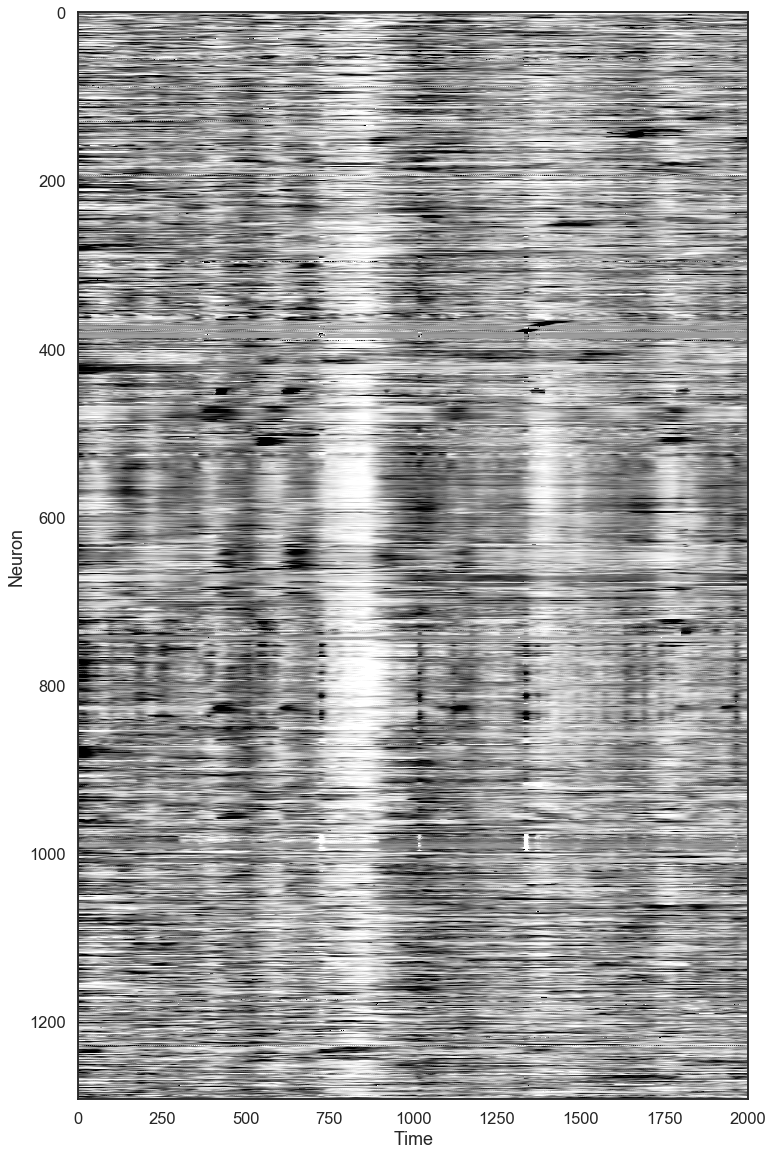

In [6]:
slc = (0, 2000)
vmin = np.quantile(data_neural[slice(*slc)], 0.01)
vmax = np.quantile(data_neural[slice(*slc)], 0.99)
plt.figure(figsize=(12, 20))
plt.imshow(
    data_neural[slice(*slc), :].T, aspect='auto', 
    cmap='Greys', vmin=vmin, vmax=vmax)
plt.xlim(0, slc[1] - slc[0])
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.show()

# 1. Dimensionality reduction through PCA

In [7]:
pca = PCA(n_components=2)
pca.fit(data['train_all'])
proj = pca.transform(data_neural)

### visualize in 2D

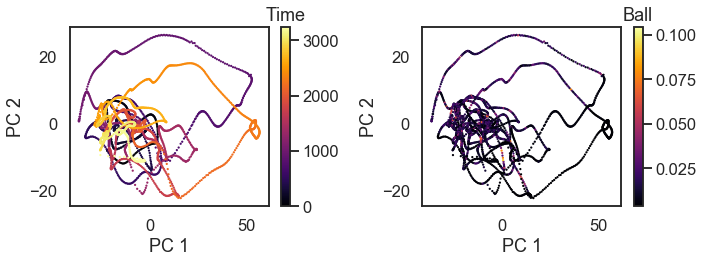

In [8]:
plt.figure(figsize=(10, 4))
    
# color PCs by time
plt.subplot(121)
plotting.plot_pcs(proj, color=np.arange(proj.shape[0]))
cbar = plt.colorbar()
cbar.ax.set_title('Time')

# color PCs by running speed
plt.subplot(122)
plotting.plot_pcs(proj, color=data_ball[:, 0])
cbar = plt.colorbar()
cbar.ax.set_title('Ball')
plt.tight_layout()
plt.show()

### what are the spatial footprints of the PCs?

In [9]:
# A = mat_contents['A']
#dims = mat_contents['dims']
# TO DO: THIS DATASET NEEDS DIMS ADDED

### what is the dimensionality of the data?

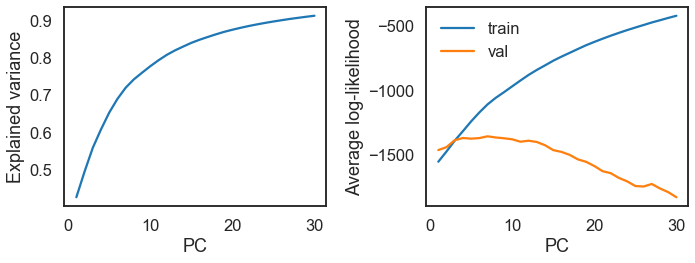

In [10]:
n_components = 30
ll_train = np.full(n_components, fill_value=np.nan)
ll_val = np.full(n_components, fill_value=np.nan)
for n in range(n_components):
    pca = PCA(n_components=n+1)
    pca.fit(data['train_all'])
    ll_train[n] = pca.score(data['train_all'])
    ll_val[n] = pca.score(data['val_all'])
    
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(np.arange(n_components)+1, np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PC')
plt.ylabel('Explained variance')

plt.subplot(122)
plt.plot(np.arange(n_components)+1, ll_train, label='train')
plt.plot(np.arange(n_components)+1, ll_val, label='val')
plt.legend(frameon=False)
plt.xlabel('PC')
plt.ylabel('Average log-likelihood')

plt.tight_layout()
plt.show()

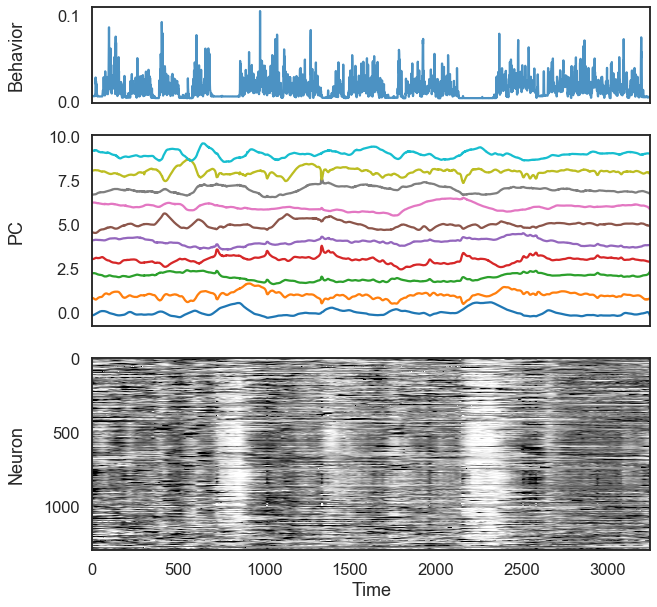

In [12]:
# plot pcs + neural activity
pca = PCA(n_components=10)
pca.fit(data['train_all'])
data_lowd = pca.transform(data_neural)    
fig = plotting.plot_neural_activity(
    pcs=zscore(data_lowd), neural_data=data_neural, behavior=behavior)

# 2. Fit dynamics

### ARHMM - start with 2 discrete states

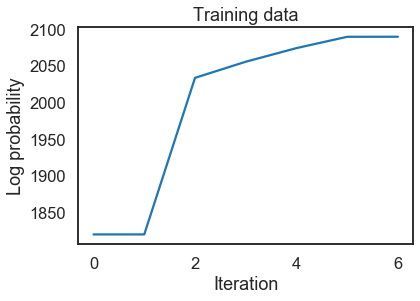

In [13]:
# first reduce dimensionality
data_pca_, data_pca = dataUtils.pca_reduce(data_neural, 10, indxs, trial_len)

model_kwargs = {'transitions': 'standard', 'observations': 'ar'}
# model_kwargs = {'transitions': 'standard', 'observations': 'gaussian'}
arhmm = HMM(K=2, D=data_pca['train'][0].shape[1], M=0, **model_kwargs)
arhmm.initialize(data_pca['train'])
arhmm.observations.initialize(data_pca['train'])

# run EM; specify tolerances for overall convergence and each M-step's convergence
logprobs = arhmm.fit(
    datas=data_pca['train'], 
    method='em', num_em_iters=50, tolerance=1e-1,
    transitions_mstep_kwargs={'optimizer': 'lbfgs', 'tol': 1e-3})

plt.figure()
plt.plot(logprobs)
plt.ylabel('Log probability')
plt.xlabel('Iteration')
plt.title('Training data')
plt.show()

### how well do these states match behavior?

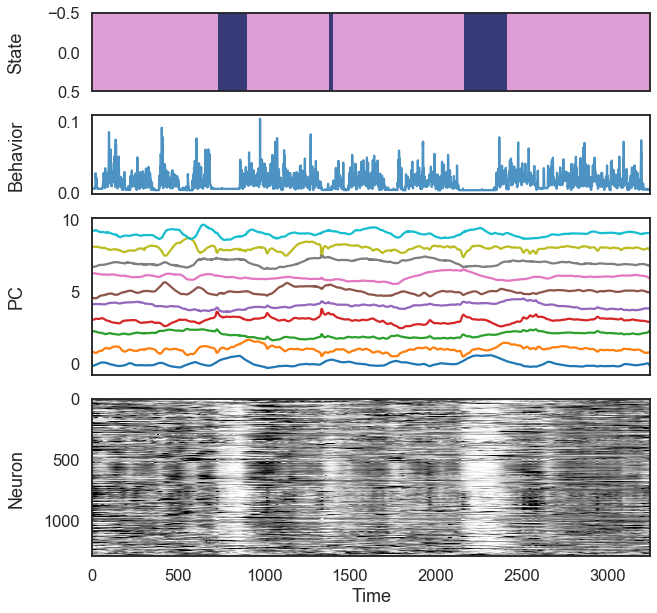

In [14]:
states_all = arhmm.most_likely_states(data_pca_)
# states_all = np.random.randint(1, 3, size=(data_pca_.shape[0], ))
fig = plotting.plot_neural_activity(
    pcs=zscore(data_lowd), neural_data=data_neural, behavior=behavior, states=states_all)

### ARHMM - how many discrete states?

In [15]:
n_states = np.arange(1, 6)
D = data_pca['train'][0].shape[1]
model_kwargs = {
#     'hmm': {
#         'transitions': 'standard', 
#         'observations': 'gaussian'},
    'arhmm': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 1}},
    'arhmm-2': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 2}},
    'arhmm-3': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 3}},
#     'arhmm-5': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
#     'arhmm-r': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
#     'arhmm-r-3': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-r-5': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
#     'arhmm-ro': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
#     'arhmm-ro-3': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-ro-5': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
}
all_results = {}
# iterate over model types
for model_name, kwargs in model_kwargs.items():
    model_results = {}
    # iterate over discrete states
    for K in n_states:
        print('Fitting %s with %i states' % (model_name, K))
        model_results[K] = utils.fit_model(
            n_states=K, data_dim=D, input_dim=0, model_kwargs=kwargs,
            data_tr=data_pca['train'], data_val=data_pca['val'], 
            data_test=data_pca['test'])
    all_results[model_name] = model_results

Fitting arhmm with 1 states



Fitting arhmm with 2 states



Fitting arhmm with 3 states



Fitting arhmm with 4 states



Fitting arhmm with 5 states



Fitting arhmm-2 with 1 states



Fitting arhmm-2 with 2 states



Fitting arhmm-2 with 3 states



Fitting arhmm-2 with 4 states



Fitting arhmm-2 with 5 states



Fitting arhmm-3 with 1 states



Fitting arhmm-3 with 2 states



Fitting arhmm-3 with 3 states



Fitting arhmm-3 with 4 states



Fitting arhmm-3 with 5 states


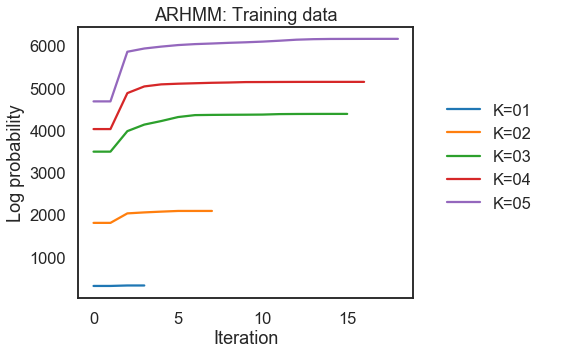

In [16]:
model_name = 'arhmm'
fig = plt.figure(figsize=(6, 5))
for K, model_result in all_results[model_name].items():
    plt.plot(model_result['lps'], label=str('K=%02i' % K))
plt.ylabel('Log probability')
plt.xlabel('Iteration')
plt.title('%s: Training data' % model_name.upper())
handles, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.55), frameon=False)
plt.show()

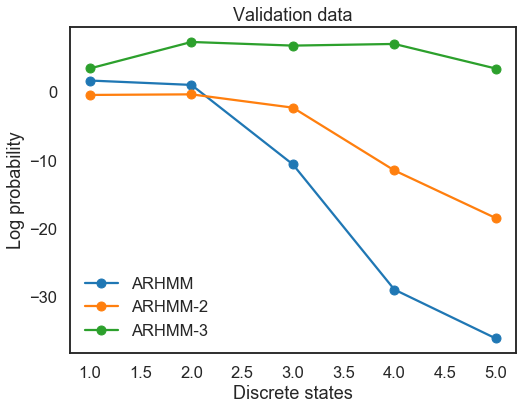

In [17]:
fig = plotting.plot_validation_likelihoods(
    all_results=all_results, 
    T_val=np.sum([d.shape[0] for d in data_pca['val']]))

### how well do these states match behavior?

In [18]:
n_states = 3
model = all_results['arhmm-3'][n_states]['model']
states_all = model.most_likely_states(data_pca_)

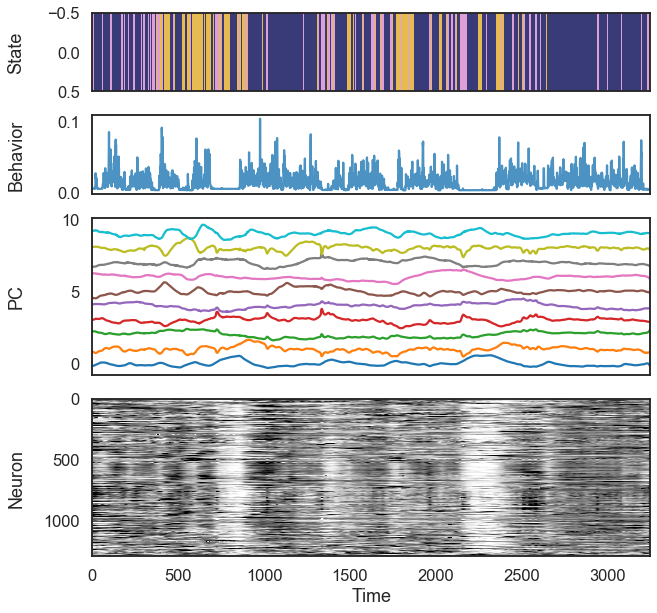

In [19]:
fig = plotting.plot_neural_activity(
    pcs=zscore(data_lowd), neural_data=data_neural, behavior=behavior, states=states_all,
    slc=(2500, 3500))

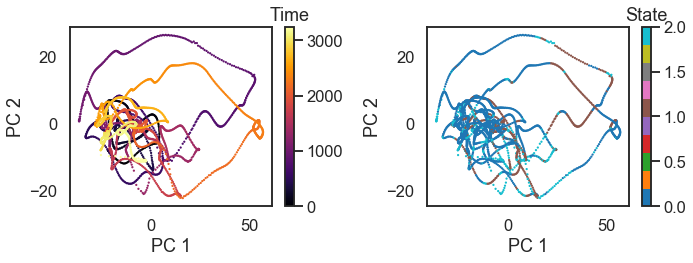

In [20]:
plt.figure(figsize=(10, 4))
    
# color PCs by time
plt.subplot(121)
plotting.plot_pcs(proj, color=np.arange(proj.shape[0]))
cbar = plt.colorbar()
cbar.ax.set_title('Time')

# color PCs by discrete state
plt.subplot(122)
plotting.plot_pcs(proj, color=model.most_likely_states(data_pca_), cmap='tab10')
cbar = plt.colorbar()
cbar.ax.set_title('State')
plt.tight_layout()
plt.show()

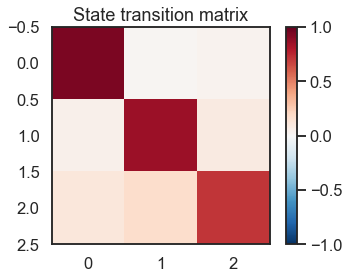

In [21]:
# plot state transition matrix
trans = np.copy(model.transitions.transition_matrix)
deridge = False
if deridge:
    n_states = trans.shape[0]
    for i in range(n_states):
        trans[i, i] = np.nan
    clim = np.nanmax(np.abs(trans))
else:
    clim = 1
plt.figure()
plt.imshow(trans, clim=[-clim, clim], cmap='RdBu_r')
plt.colorbar()
plt.title('State transition matrix')
plt.show()

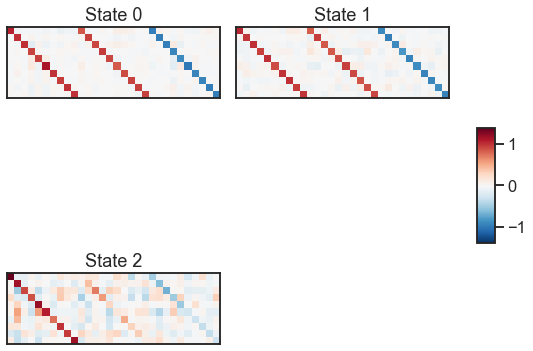

In [22]:
fig = plotting.plot_dynamics_matrices(model, deridge=False)

# 3. Fit dynamics on subsets of cells

### plot raster of PCA reconstructions

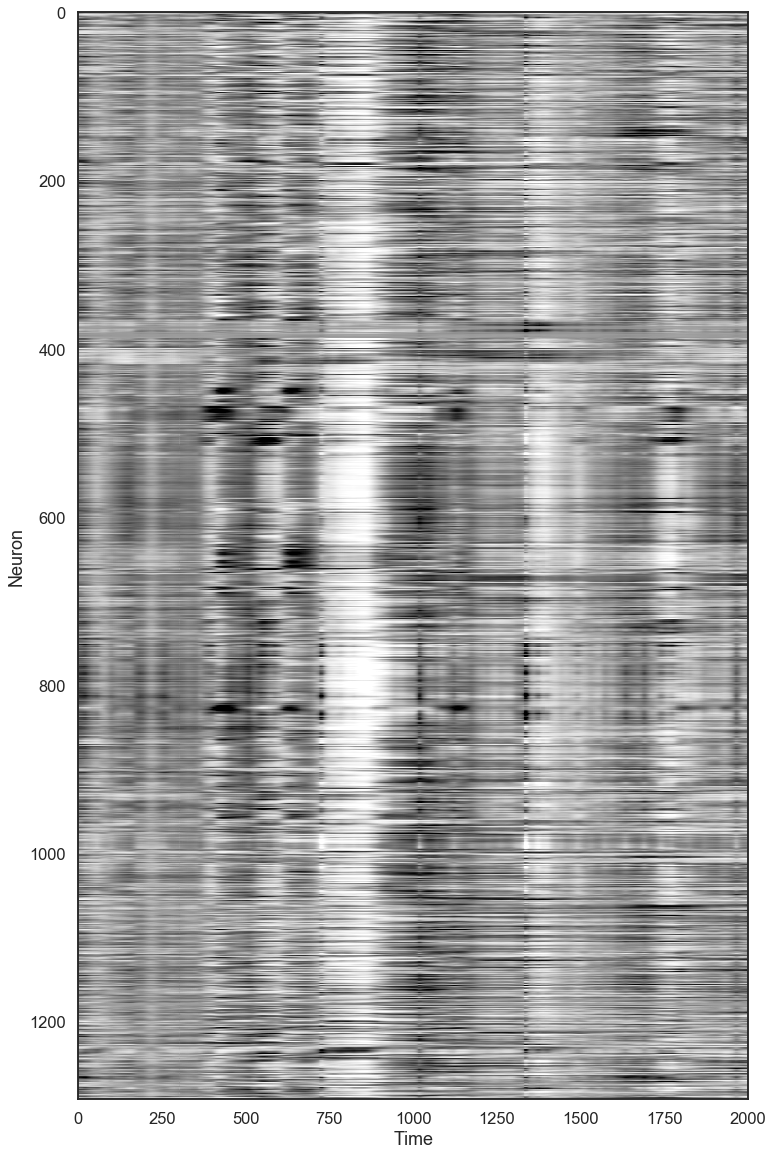

In [23]:
pca = PCA(n_components=10)
pca.fit(data['train_all'])
data_neural_recon = pca.inverse_transform(pca.transform(data_neural))

slc = (0, 2000)
vmin = np.quantile(data_neural[slice(*slc)], 0.01)
vmax = np.quantile(data_neural[slice(*slc)], 0.99)
plt.figure(figsize=(12, 20))
plt.imshow(
    data_neural_recon[slice(*slc), :].T, aspect='auto', 
    cmap='Greys', vmin=vmin, vmax=vmax)
plt.xlim(0, slc[1] - slc[0])
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.show()

### plot raster of cell activities

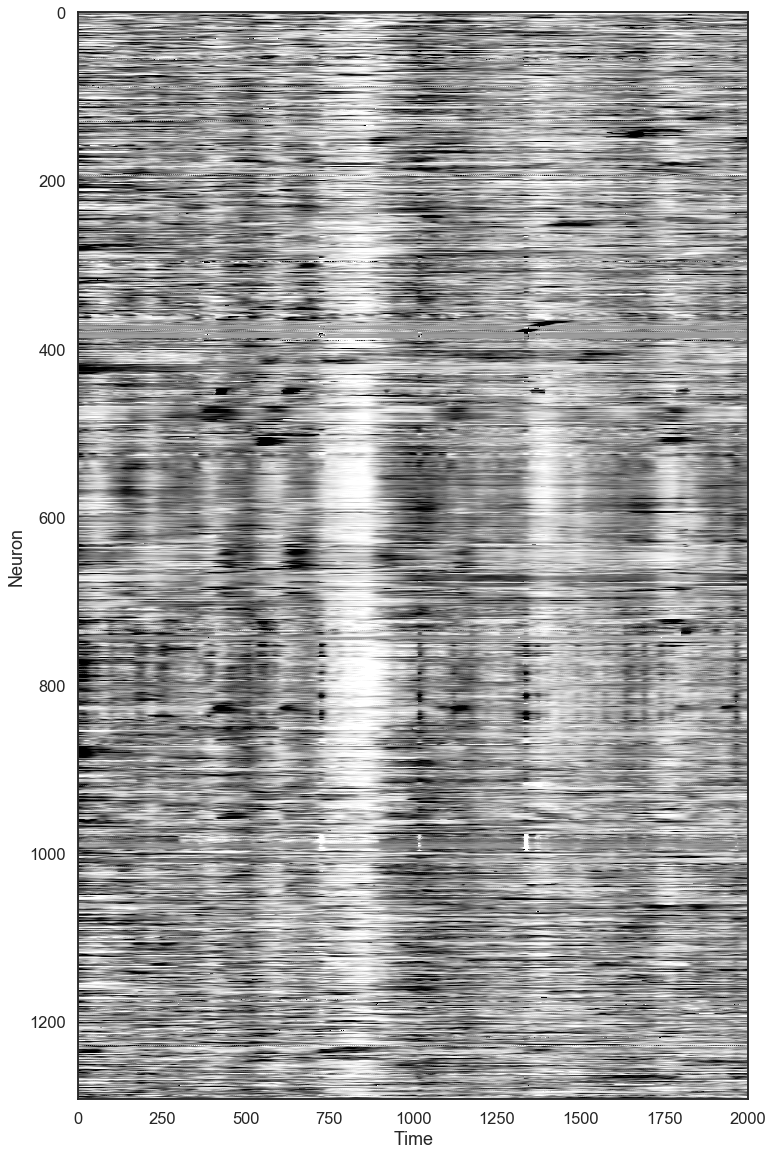

In [24]:
slc = (0, 2000)
vmin = np.quantile(data_neural[slice(*slc)], 0.01)
vmax = np.quantile(data_neural[slice(*slc)], 0.99)
plt.figure(figsize=(12, 20))
plt.imshow(
    data_neural[slice(*slc), :].T, aspect='auto', 
    cmap='Greys', vmin=vmin, vmax=vmax)
plt.xlim(0, slc[1] - slc[0])
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.show()

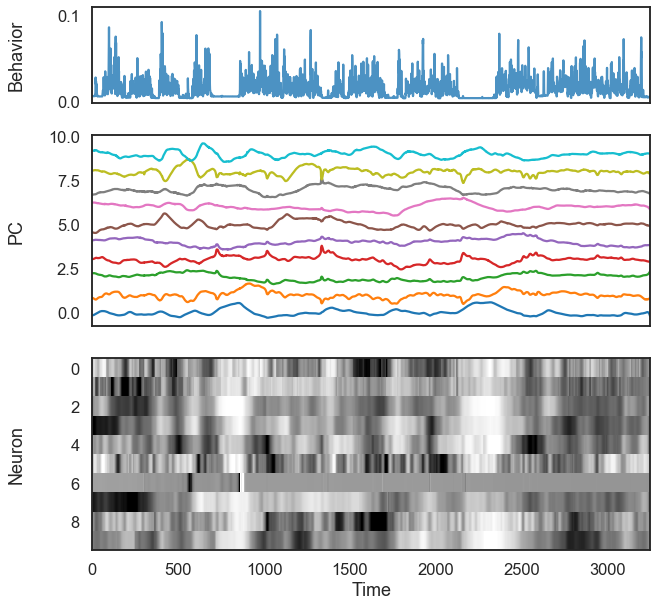

In [25]:
# plot pcs + neural activity
pca = PCA(n_components=10)
pca.fit(data['train_all'])
data_lowd = pca.transform(data_neural)    
cell_indxs = np.arange(130, 140)
fig = plotting.plot_neural_activity(
    pcs=zscore(data_lowd), neural_data=data_neural[:, cell_indxs], behavior=behavior)

### sub-population: 2 states

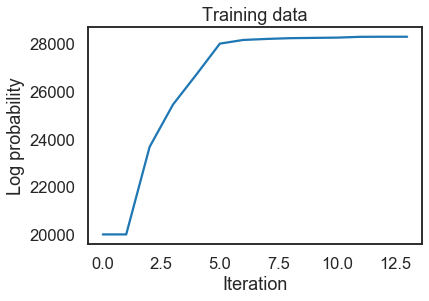

In [26]:
# first subsample cells
# cell_indxs = np.arange(205, 220)
cell_indxs = np.arange(130, 140)
data_sub_, data_sub = dataUtils.subsample_cells(data_neural, cell_indxs, indxs, trial_len)

model_kwargs = {'transitions': 'standard', 'observations': 'ar'}

arhmm = HMM(K=2, D=data_sub['train'][0].shape[1], M=0, **model_kwargs)
arhmm.initialize(data_sub['train'])
arhmm.observations.initialize(data_sub['train'])

# run EM; specify tolerances for overall convergence and each M-step's convergence
logprobs = arhmm.fit(
    datas=data_sub['train'], 
    method='em', num_em_iters=50, tolerance=1e-1,
    transitions_mstep_kwargs={'optimizer': 'lbfgs', 'tol': 1e-3})

plt.figure()
plt.plot(logprobs)
plt.ylabel('Log probability')
plt.xlabel('Iteration')
plt.title('Training data')
plt.show()

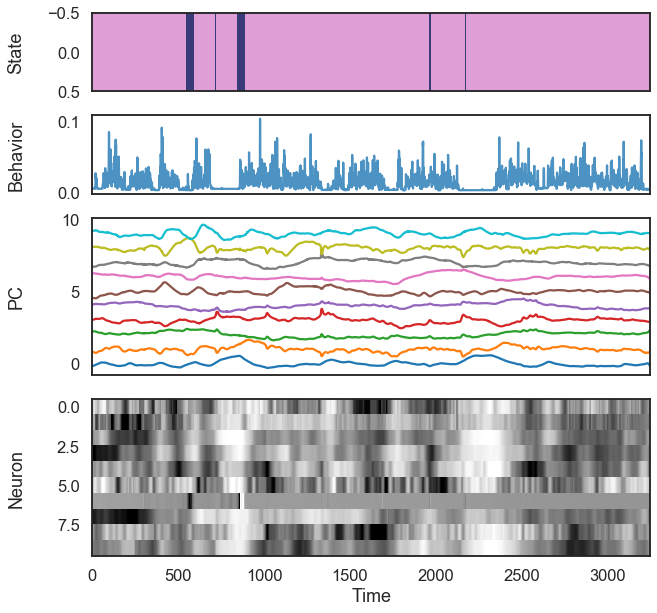

In [27]:
states_all = arhmm.most_likely_states(data_sub_)
# states_all = np.random.randint(1, 3, size=(data_pca_.shape[0], ))
fig = plotting.plot_neural_activity(
    pcs=zscore(data_lowd), neural_data=data_sub_, behavior=behavior, states=states_all)

In [28]:
n_states = np.arange(1, 7)
D = data_sub['train'][0].shape[1]
model_kwargs = {
    'hmm': {
        'transitions': 'standard', 
        'observations': 'gaussian'},
    'arhmm': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 1}},
#     'arhmm-2': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 2}},
#     'arhmm-3': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-5': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
    'arhmm-r': {
        'transitions': 'recurrent', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 1}},
#     'arhmm-r-3': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-r-5': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
    'arhmm-ro': {
        'transitions': 'recurrent_only', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 1}},
#     'arhmm-ro-3': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-ro-5': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
}
all_results = {}
# iterate over model types
for model_name, kwargs in model_kwargs.items():
    model_results = {}
    # iterate over discrete states
    for K in n_states:
        print('Fitting %s with %i states' % (model_name, K))
        model_results[K] = utils.fit_model(
            n_states=K, data_dim=D, input_dim=0, model_kwargs=kwargs,
            data_tr=data_sub['train'], data_val=data_sub['val'], 
            data_test=data_sub['test'])
    all_results[model_name] = model_results

Fitting hmm with 1 states



Fitting hmm with 2 states



Fitting hmm with 3 states



Fitting hmm with 4 states


/home/mattw/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: Degrees of freedom <= 0 for slice
  return f_raw(*args, **kwargs)
/home/mattw/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/mattw/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


AssertionError: 

In [29]:
import copy
all_results_ = copy.copy(all_results)
# _ = all_results_.pop('hmm')
_ = all_results_.pop('arhmm')
_ = all_results_.pop('arhmm-r')
_ = all_results_.pop('arhmm-ro')
fig = plotting.plot_validation_likelihoods(
    all_results=all_results_, 
    T_val=np.sum([d.shape[0] for d in data_sub['val']]))

KeyError: 'arhmm'

In [ ]:
n_states = 5
model = all_results['arhmm'][n_states]['model']
states_all = model.most_likely_states(data_sub_)

# fig = plot_neural_activity(
#     pcs=zscore(data_lowd), neural_data=data_sub_, behavior=behavior, states=states_all,
#     slc=(2000, 3500))
fig = plotting.plot_neural_activity(
    pcs=None, neural_data=data_sub_, behavior=behavior, states=states_all,
    slc=(2000, 3500))

## Notes
<br>

* In C. elegans, neural circuits that respond to appetitive cues alter transition probabilities between a core set of locomotor-related behavioral modules, thereby creating new behavioral sequences that enable taxis toward attractive odorants